In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
from tqdm import tqdm

In [3]:
def read_data(file_name):
    data_dir = 'courses'
    data = []
    for fld in os.listdir(data_dir)[:3]:
        data.append(pd.read_csv(f'{data_dir}/{fld}/{file_name}'))
    return pd.concat(data)

In [4]:
course_n = 560
course_element = pd.read_csv('courses/' + str(course_n) + '/course_element.csv')
course_module = pd.read_csv('courses/' + str(course_n) + '/course_module.csv')
course = pd.read_csv('courses/' + str(course_n) + '/course.csv')
solution_log = pd.read_csv('courses/' + str(course_n) + '/solution_log.csv')
user_course_progress = pd.read_csv('courses/' + str(course_n) + '/user_course_progress.csv')
user_element_progress = pd.read_csv('courses/' + str(course_n) + '/user_element_progress.csv')
user_module_progress = pd.read_csv('courses/' + str(course_n) + '/user_module_progress.csv')

In [5]:
class Metric:
    def __init__(self, metric_name, 
                 course_element=None, course_module=None, course=None,
                solution_log=None, user_course_progress=None,
                user_element_progress=None, user_module_progress=None):
        self.metric_name = metric_name
        self.course_element = course_element
        self.course_module = course_module
        self.course = course
        self.solution_log = solution_log
        self.user_course_progress = user_course_progress
        self.user_element_progress = user_element_progress
        self.user_module_progress = user_module_progress


    def modules_list(self):
        return list(self.course_module.id)


    def tasks_list(self):
        pass
    def module_tasks_list(self, module_id):
        course_element =self.course_element[['id', 'module_id',
                                             'element_type', 'element_id']]
        course_element = course_element[course_element.module_id == module_id]
        course_element = course_element[course_element.element_type == 'task']
        return list(course_element.element_id)


    def evaluate(self, *args, **kwargs):
        raise NotImplemetedError


    def __call__(self):
        raise NotImplementedError


class MetricsCalculator:
    def __init__(self, metrics_list):
        self.metrics_list = metrics_list

    
    def calculate_metrics(self):
        output = []
        for metric in self.metrics_list:
            output.append(metric())
        return output

# Медианное время, потраченное пользователями на задачу

In [6]:
# solved - df с задачами, которые пользователи решили
solved = user_element_progress[user_element_progress['course_element_type'] == 'task']
solved = solved[solved['achieve_reason'] == 'solved']
# solved_ids - список с номерами прогресса по решенным задачам
solved_ids = list(solved.id.value_counts().index)

Считаю следующим образом: \
Для каждого *id* прогресса по **решенной задаче** из *user_element_progress.csv* в файле *solution_log.csv* беру информацию обо всех попытках каждого ученика по каждой задаче, считаю разность времени между соседними попытками и суммирую те, которые < *user_session* минут

In [7]:
tasks_time = []
long_attempts_counter = 0
user_session = 40
for id in solved_ids:
    df = solution_log[solution_log.element_progress_id == id].sort_values('tries_count',
                                                                          ascending=False).submission_time
    task_time = 0
    for i in range(len(df) - 1):
        stop = datetime.datetime.fromisoformat(df.iloc[i])
        start = datetime.datetime.fromisoformat(df.iloc[i + 1])
        attempt_time = (stop - start).total_seconds() / 60
        if attempt_time < user_session:
            task_time += attempt_time
        else:
            long_attempts_counter += 1
    tasks_time.append(task_time)

In [8]:
solved_log  = solution_log[solution_log.element_progress_id.isin(solved_ids)]
print(f'Общее число попыток: {len(solved_log)}')
print(f'Число "долгих" попыток: {long_attempts_counter}')

Общее число попыток: 136507
Число "долгих" попыток: 4756


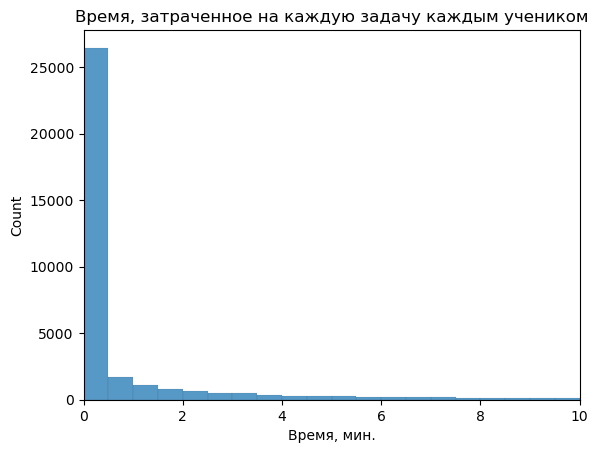

In [9]:
fig, ax = plt.subplots()
ax = sns.histplot(tasks_time, binwidth=0.5)
ax.set_xlim((0, 10))
ax.set_xlabel('Время, мин.')
plt.title('Время, затраченное на каждую задачу каждым учеником')
plt.show()

In [10]:
class TaskTime(Metric):
    def __init__(self, metric_name, 
                 course_element=None, course_module=None, course=None,
                solution_log=None, user_course_progress=None,
                user_element_progress=None, user_module_progress=None):
        super().__init__(metric_name, 
                 course_element, course_module, course,
                solution_log, user_course_progress,
                user_element_progress, user_module_progress)
        self.user_session = 40


    def __call__(self, metric=np.mean, display_progress=False):
        if metric == 'mean':
            metric = np.mean
        else:
            metric = np.median
        output = []
        solved_tasks = self.user_element_progress[self.user_element_progress.course_element_type == 'task']
        solved_tasks = solved_tasks[solved_tasks.achieve_reason == 'solved']
        tasks_list = np.unique(solved_tasks.course_element_id)
        for task in tasks_list:
            users_time = []
            progress_ids = solved_tasks[solved_tasks.course_element_id == task].id
            for id in progress_ids:
                df = self.solution_log[self.solution_log.element_progress_id == id].sort_values('tries_count',
                                                                                      ascending=False).submission_time
                user_time = 0
                for i in range(len(df) - 1):
                    stop = datetime.datetime.fromisoformat(df.iloc[i])
                    start = datetime.datetime.fromisoformat(df.iloc[i + 1])
                    attempt_time = (stop - start).total_seconds() / 60
                    if attempt_time < user_session:
                        user_time += attempt_time
                users_time.append(user_time)   
            output.append(metric(users_time))
        return pd.DataFrame({'element_id' : tasks_list, self.metric_name : output})

In [11]:
task_time = TaskTime('task_time',user_element_progress=user_element_progress, solution_log=solution_log)
median_time = task_time(metric ='median')
mean_time = task_time(metric='mean')

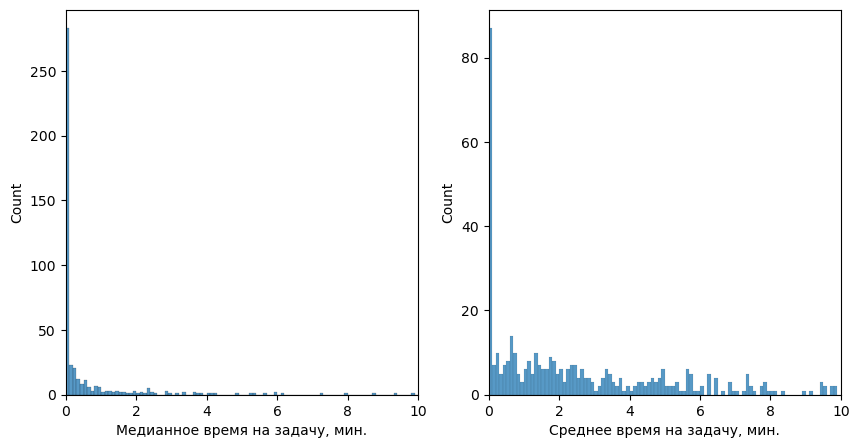

In [12]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0] = sns.histplot(median_time.task_time, ax=ax[0], binwidth=0.1)
ax[0].set_xlim((0, 10))
ax[0].set_xlabel('Медианное время на задачу, мин.')
ax[1] = sns.histplot(mean_time.task_time, ax=ax[1], binwidth=0.1)
ax[1].set_xlim((0, 10))
ax[1].set_xlabel('Среднее время на задачу, мин.')
plt.show()

In [13]:
n_tasks = (course_element.element_type == 'task').sum()
print(f'Общее число задач: {n_tasks}')
median_time_np = np.array(median_time.task_time)
mean_time_np = np.array(mean_time.task_time)
print(f'Число задач, которые решили с первой попытки по медиане: {(median_time_np == 0).sum()}')
print(f'Число задач, которые решили с первой попытки в среднем: {(mean_time_np == 0).sum()}')

Общее число задач: 442
Число задач, которые решили с первой попытки по медиане: 257
Число задач, которые решили с первой попытки в среднем: 80


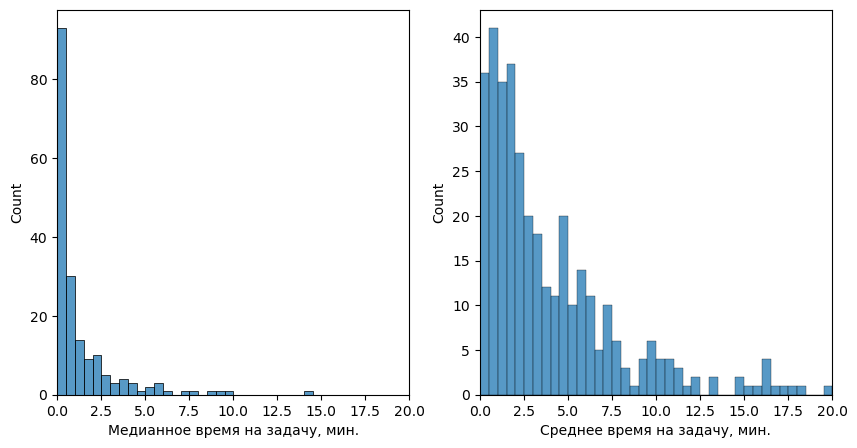

In [14]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0] = sns.histplot(median_time_np[median_time_np > 0], ax=ax[0], binwidth=0.5)
ax[0].set_xlim((0, 20))
ax[0].set_xlabel('Медианное время на задачу, мин.')
ax[1] = sns.histplot(mean_time_np[mean_time_np > 0], ax=ax[1], binwidth=0.5)
ax[1].set_xlim((0, 20))
ax[1].set_xlabel('Среднее время на задачу, мин.')
plt.show()

In [15]:
median_threshold = 1
mean_threshold = 7.5
print(f'Доля сложных задач по медиане: {(median_time_np > median_threshold).sum() /n_tasks}')
print(f'Доля сложных задач в среднем: {(mean_time_np > mean_threshold).sum()/n_tasks}')

Доля сложных задач по медиане: 0.14027149321266968
Доля сложных задач в среднем: 0.12669683257918551


# Медианное время, потраченное на модуль

In [16]:
class ModuleTime(Metric):
    def __init__(self, metric_name, 
                 course_element=None, course_module=None, course=None,
                solution_log=None, user_course_progress=None,
                user_element_progress=None, user_module_progress=None):
        super().__init__(metric_name, 
                 course_element, course_module, course,
                solution_log, user_course_progress,
                user_element_progress, user_module_progress)
        self.user_session = 40


    def __call__(self, metric='mean', solved=False):
        output = []
        achieved_modules = self.user_module_progress[self.user_module_progress.achieve_reason == 'solved']
        if solved:
            achieved_modules = achieved_modules[achieved_modules.is_solved]
        else:
            achieved_modules = achieved_modules[achieved_modules.is_achieved]
        modules_list = np.unique(achieved_modules.course_module_id)
        module_progress_ids = np.array(achieved_modules.id)
        solved_tasks = self.user_element_progress[self.user_element_progress.module_progress_id.isin(module_progress_ids)]
        solved_tasks = solved_tasks[solved_tasks.course_element_type == 'task']
        solved_tasks = solved_tasks[solved_tasks.achieve_reason == 'solved']
        for module in module_progress_ids:
            module_time = []
            user_progress_ids = solved_tasks[solved_tasks.module_progress_id == module].id
            for id in user_progress_ids:
                df = self.solution_log[self.solution_log.element_progress_id == id].sort_values('tries_count',
                                                                                      ascending=False).submission_time
                user_time = 0
                for i in range(len(df) - 1):
                    stop = datetime.datetime.fromisoformat(df.iloc[i])
                    start = datetime.datetime.fromisoformat(df.iloc[i + 1])
                    attempt_time = (stop - start).total_seconds() / 60
                    if attempt_time < user_session:
                        user_time += attempt_time
                module_time.append(user_time)
            output.append(np.sum(module_time))
        output = pd.DataFrame({'id' : module_progress_ids,'user_time' : output})
        output = pd.merge(achieved_modules.loc[:,['id','course_module_id']],output,on='id')
        if metric == 'mean':
            output = output.groupby('course_module_id')['user_time'].mean()
        else:
            output = output.groupby('course_module_id')['user_time'].median()
        return pd.DataFrame({'course_module_id': output.index, self.metric_name: list(output)})

In [17]:
course_element_all = read_data('course_element.csv')
course_module_all = read_data('course_module.csv')
course_all = read_data('course.csv')
solution_log_all = read_data('solution_log.csv')
user_course_progress_all = read_data('user_course_progress.csv')
user_element_progress_all = read_data('user_element_progress.csv')
user_module_progress_all = read_data('user_module_progress.csv')

In [18]:
module_time = ModuleTime('module_time', user_element_progress=user_element_progress_all,user_module_progress=user_module_progress_all,
               solution_log=solution_log_all)
mean_module_time = module_time(metric='mean')

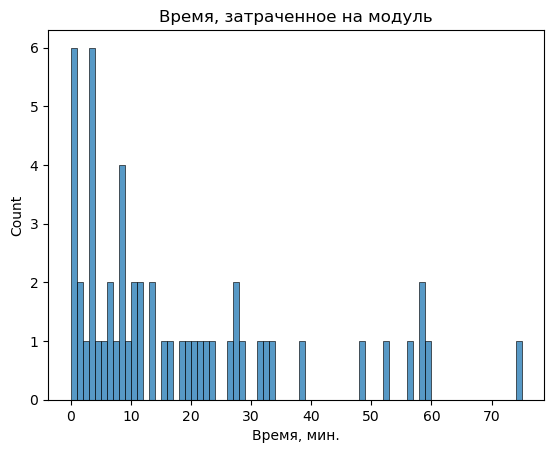

In [19]:
fig, ax = plt.subplots()
ax = sns.histplot(mean_module_time.module_time, binwidth=1)
ax.set_xlabel('Время, мин.')
plt.title('Время, затраченное на модуль')
plt.show()

# Медиана по пользователям отклонения времени на задачу от медианного по модулю у данного пользователя

In [20]:
class TaskTimeDeviation(Metric):
    def __init__(self, metric_name, 
                 course_element=None, course_module=None, course=None,
                solution_log=None, user_course_progress=None,
                user_element_progress=None, user_module_progress=None):
        super().__init__(metric_name, 
                 course_element, course_module, course,
                solution_log, user_course_progress,
                user_element_progress, user_module_progress)
        self.user_session = 40

    def __call__(self, task_metric='mean'):
        if task_metric == 'mean':
            metric = np.mean
        else:
            metric = np.median
        solved_tasks = self.user_element_progress[self.user_element_progress.course_element_type == 'task']
        solved_tasks = solved_tasks[solved_tasks.achieve_reason == 'solved']
        users_time = []
        for id in solved_tasks.id:
            df = self.solution_log[self.solution_log.element_progress_id == id].sort_values('tries_count',
                                                                                  ascending=False).submission_time
            user_time = 0
            for i in range(len(df) - 1):
                stop = datetime.datetime.fromisoformat(df.iloc[i])
                start = datetime.datetime.fromisoformat(df.iloc[i + 1])
                attempt_time = (stop - start).total_seconds() / 60
                if attempt_time < user_session:
                    user_time += attempt_time
            users_time.append(user_time)
        users_time = pd.DataFrame({'id' : list(solved_tasks.id), 'user_time' : users_time})
        solved_tasks = pd.merge(solved_tasks, users_time, on='id')
        median_module_time = []
        module_progress_ids = np.unique(solved_tasks.module_progress_id)
        for id in module_progress_ids:
            median_module_time.append(metric(solved_tasks[solved_tasks.module_progress_id == id].user_time))
        median_module_time = pd.DataFrame({'module_progress_id' : module_progress_ids, 'median_module_time' : median_module_time})
        solved_tasks = pd.merge(solved_tasks, median_module_time, on = 'module_progress_id')
        solved_tasks.user_time -= solved_tasks.median_module_time
        if task_metric == 'median':
            output = solved_tasks.groupby('course_element_id')['user_time'].median()
        else:
            output = solved_tasks.groupby('course_element_id')['user_time'].mean()
        return pd.DataFrame({'course_element_id' : output.index, self.metric_name : list(output)})

In [21]:
task_time = TaskTimeDeviation('time_deviation',user_element_progress=user_element_progress, solution_log=solution_log)
median_dev = task_time(task_metric='median')
mean_dev = task_time(task_metric='mean')

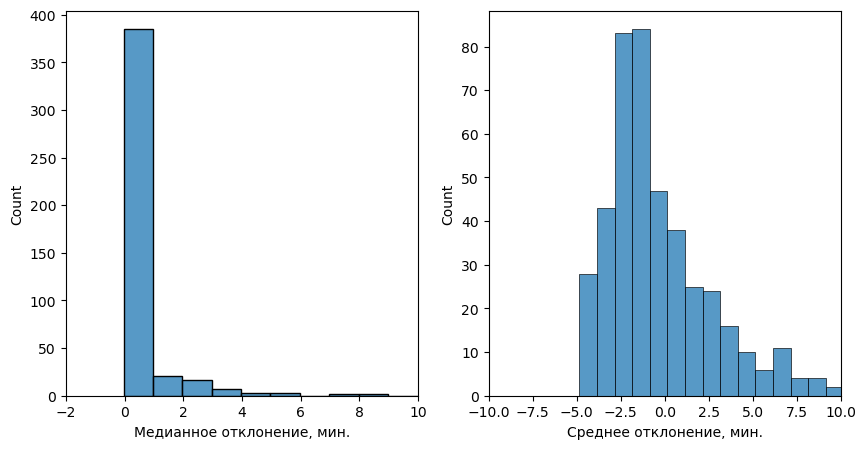

In [22]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0] = sns.histplot(median_dev.time_deviation, ax=ax[0], binwidth=1)
ax[0].set_xlim((-2, 10))
ax[0].set_xlabel('Медианное отклонение, мин.')
ax[1] = sns.histplot(mean_dev.time_deviation, ax=ax[1], binwidth=1)
ax[1].set_xlim((-10, 10))
ax[1].set_xlabel('Среднее отклонение, мин.')
plt.show()

In [24]:
median_dev_np = np.array(median_dev.time_deviation)
mean_dev_np = np.array(mean_dev.time_deviation)
print(f'Доля простых задач по медиане: {(median_dev_np < 0).sum() / n_tasks}')
print(f'Доля простых задач в среднем: {(mean_dev_np < 0).sum() / n_tasks}')

Доля простых задач по медиане: 0.004524886877828055
Доля простых задач в среднем: 0.6266968325791855


In [25]:
median_dev_threshold = 1
mean_dev_threshold = 7.5
print(f'Доля сложных задач по медиане: {(median_time_np > median_dev_threshold).sum() /n_tasks}')
print(f'Доля сложных задач в среднем: {(mean_time_np > mean_dev_threshold).sum()/n_tasks}')

Доля сложных задач по медиане: 0.14027149321266968
Доля сложных задач в среднем: 0.12669683257918551


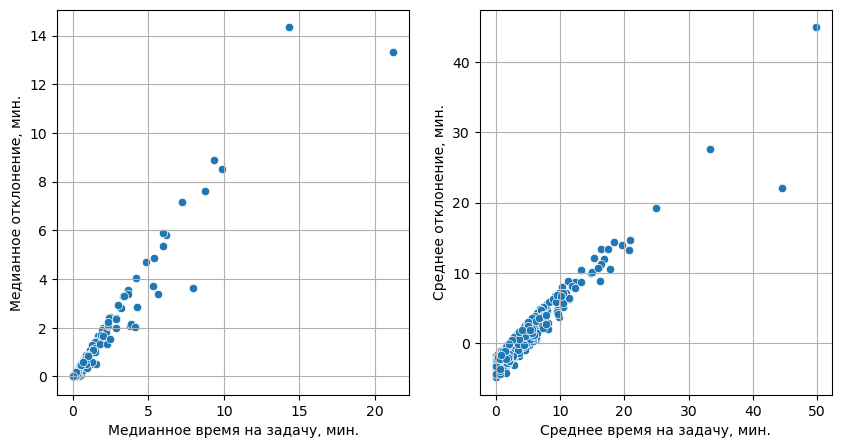

In [26]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0] = sns.scatterplot(x=median_time_np,y=median_dev_np, ax=ax[0])
ax[0].set_xlabel('Медианное время на задачу, мин.')
ax[0].set_ylabel('Медианное отклонение, мин.')
ax[0].grid()
ax[1] = sns.scatterplot(x=mean_time_np,y=mean_dev_np, ax=ax[1])
ax[1].set_xlabel('Среднее время на задачу, мин.')
ax[1].set_ylabel('Среднее отклонение, мин.')
ax[1].grid()
plt.show()